In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn

## 1. Import dataset and perform analysing

In [3]:
df = pd.read_csv('../Datasets/income.csv')

In [4]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30000 non-null  int64 
 1   sex             30000 non-null  object
 2   education       30000 non-null  object
 3   education-num   30000 non-null  int64 
 4   marital-status  30000 non-null  object
 5   workclass       30000 non-null  object
 6   occupation      30000 non-null  object
 7   hours-per-week  30000 non-null  int64 
 8   income          30000 non-null  object
 9   label           30000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.3+ MB


In [6]:
df['label'].value_counts()

0    21700
1     8300
Name: label, dtype: int64

## 2. Separate cat and con columns

In [34]:
cat_cols = ['sex', 'education-num', 'marital-status', 'workclass', 'occupation']

cats = np.stack([df[col].astype("category").cat.codes.values for col in cat_cols], 1)

cats = torch.tensor(cats, dtype=torch.int32)

cats[:5]

tensor([[ 1,  6,  3,  2,  1],
        [ 1, 11,  1,  1,  2],
        [ 1,  6,  0,  3,  7],
        [ 0, 12,  3,  0,  7],
        [ 0,  4,  5,  2,  3]], dtype=torch.int32)

In [35]:
cont_cols = ['age', 'hours-per-week']
conts = np.stack([df[col] for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float32)
conts[:5]

tensor([[27., 40.],
        [47., 50.],
        [59., 20.],
        [38., 57.],
        [64., 40.]])

In [9]:
y = df['label'].values
y = torch.tensor(y).flatten()
y[:5]

tensor([0, 1, 0, 1, 0])

In [10]:
len(df['sex'].astype("category").values.categories)

2

## 3. Set embedding size

In [11]:
cat_sz = [len(df[col].astype("category").values.categories) for col in cat_cols]

emb_sz = [(sz, min((sz + 1) // 2, 50)) for sz in cat_sz]
emb_sz

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

## 4. Create train/test sets from cats, conts and y

In [36]:
b_sz = 30000
t_sz = 5000

cat_tr = cats[:b_sz-t_sz]
cat_te = cats[b_sz-t_sz:b_sz]
cont_tr = conts[:b_sz-t_sz]
cont_te = conts[b_sz-t_sz:b_sz]

y_tr = y[:b_sz - t_sz]
y_te = y[b_sz - t_sz:b_sz]

In [37]:
cat_tr.dtype

torch.int32

## 5. Define the model class

In [13]:
embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sz])
embeds

ModuleList(
  (0): Embedding(2, 1)
  (1): Embedding(14, 7)
  (2): Embedding(6, 3)
  (3): Embedding(5, 3)
  (4): Embedding(12, 6)
)

In [38]:
class TabularModel(nn.Module):
    def __init__(self, emb_sz, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sz])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []

        n_emb = sum([nf for ni, nf in emb_sz])
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d
            (i))
            layerlist.append(nn.Dropout(p))
        
        layerlist.append(nn.Linear(layers[-1], out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i])) # column wise mapping of categorical variables onto list of tensor embeddings
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [24]:
torch.manual_seed(33)
model = TabularModel(emb_sz, conts.shape[1], 2, [50], p=.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

## 6. Define the loss and activation functions

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 7. Train the model

In [43]:
epochs = 300

losses = []

for i in range(epochs):
    i += 1
    y_pred = model(cat_tr, cont_tr)
    loss = criterion(y_pred, y_tr)
    losses.append(loss)

    if i % 10 == 0:
        print(f'epoch: {i}   |   loss: {loss:8.2f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 10   |   loss:     0.47
epoch: 20   |   loss:     0.37
epoch: 30   |   loss:     0.33
epoch: 40   |   loss:     0.32
epoch: 50   |   loss:     0.30
epoch: 60   |   loss:     0.30
epoch: 70   |   loss:     0.29
epoch: 80   |   loss:     0.29
epoch: 90   |   loss:     0.29
epoch: 100   |   loss:     0.28
epoch: 110   |   loss:     0.28
epoch: 120   |   loss:     0.28
epoch: 130   |   loss:     0.28
epoch: 140   |   loss:     0.28
epoch: 150   |   loss:     0.28
epoch: 160   |   loss:     0.28
epoch: 170   |   loss:     0.27
epoch: 180   |   loss:     0.28
epoch: 190   |   loss:     0.27
epoch: 200   |   loss:     0.27
epoch: 210   |   loss:     0.27
epoch: 220   |   loss:     0.27
epoch: 230   |   loss:     0.27
epoch: 240   |   loss:     0.27
epoch: 250   |   loss:     0.27
epoch: 260   |   loss:     0.27
epoch: 270   |   loss:     0.27
epoch: 280   |   loss:     0.27
epoch: 290   |   loss:     0.27
epoch: 300   |   loss:     0.27


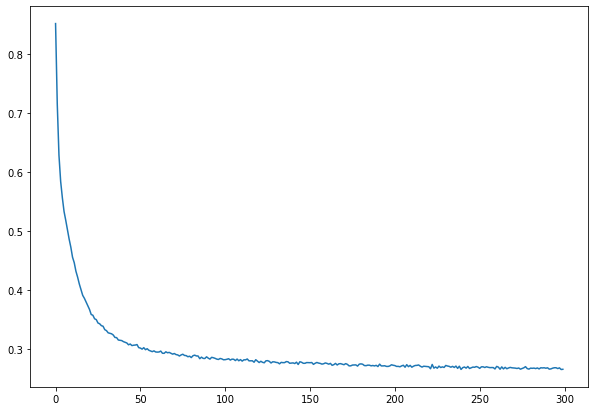

In [53]:
plt.figure(figsize=(10, 7))
plt.plot(range(epochs), losses)

## 7. Evaluate the test set

In [62]:
with torch.no_grad():
    y_eval = model(cat_te, cont_te)
    loss = criterion(y_val, y_te)

print(loss)

tensor(0.2751)


In [74]:
correct = 0

for i in range(len(y_te)):
    # print(y_eval[i].argmax().item(), ' | ', y_te[i].item())
    if y_eval[i].argmax().item() == y_te[i]:
        correct += 1

print(f'The accuracy of the model is: {correct/len(y_te)} with {correct} correct overr {len(y_te)}')

The accuracy of the model is: 0.8706 with 4353 correct overr 5000
